# Using TESSreduce to get light curves
    
TESS offers the exciting possibility of high cadence photometry for hundreds of transients across the sky, but the bright complex background can present challenges. With TESSreduce, we can subtract the TESS background accounting for both the smooth background and the discrete background caused by detector straps from any Target Pixel File extracted from the Full Frame Images. 

In this notebook we will go through the steps that are used in the construction of TESSreduce light curves. For this example lets look at SN 2019esa, a type II supernova in sector 11.

This package is based on the Lightkurve package and operates on the TESStargetpixelfile class.

In [1]:
import tessreduce as tr
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np

the Coordinates of SN2019esa

In [2]:
ra = 118.7537042
dec = -76.411975
sector = 11
size = 90

We can get a tpf cutout from the FFIs by utilising TESScut through the Get_TESS command. To get an accurate assesment of the background around our target, we need a large cutout. Depending on how crowded the field is 30x30 cutouts can work, although its safe to stick to a large 90x90 cutout and change if needed.

In [3]:
tpf = tr.Get_TESS(ra,dec,size,sector)

SN2019esa lies at the centre of this tpf but its currently hidden by the background

<IPython.core.display.Javascript object>


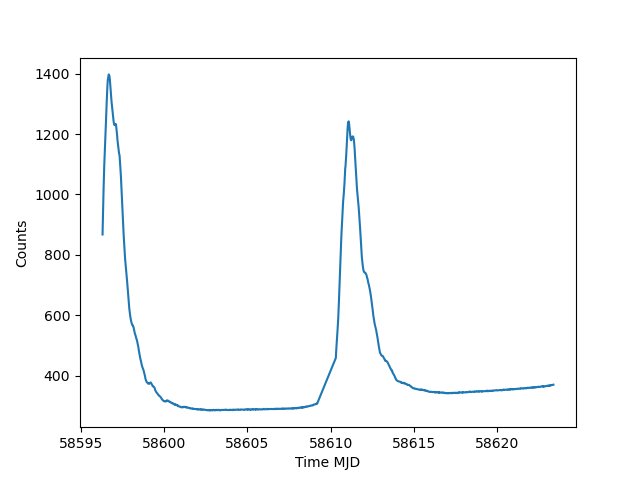

In [4]:
tr.Plotter(tpf.astropy_time.mjd,tpf.flux[:,45,45])

Before we can do any science the background needs to be removed. The first step to background subtraction is to identify all pixels with sources in them and create a source mask.

To make sure we don't end up with asteroids or other wierd things in the mask, lets make a reference image.

In [5]:
ref = tr.Get_ref(tpf.flux)

This reference is the median of all frames that have the lowest background flux in them. This condition helps avoid brighter background areas, such as straps, from being masked and excluded from the background fitting. If you want to make another reference image with a specific time interval you can do that by setting one, or both, of the start and stop variables in tr.Get_ref().

With the reference defined we can now calculate the source mask.

In [6]:
mask = tr.Source_mask(ref)

With source mask we can now go ahead and calculate the background for all frames in the tpf. There are a lot of frames in a tpf (>1000), so determining can be quite slow, we can fix this by working in parallel! 

This background determination method works in a few steps:
1. Masks out sources
2. Masks out all columns contamiated by straps
3. Calculate and the smooth background through interpolation and extrapolation (extrapolation information is stored in the bitmask variable)
4. Subtract the smooth background from all pixels
5. Calculate the background profile for each strap column individually 
6. Subtract the strap background

In [7]:
bkg = tr.Background(tpf,mask,parallel=True)
flux = tpf.flux - bkg

<IPython.core.display.Javascript object>


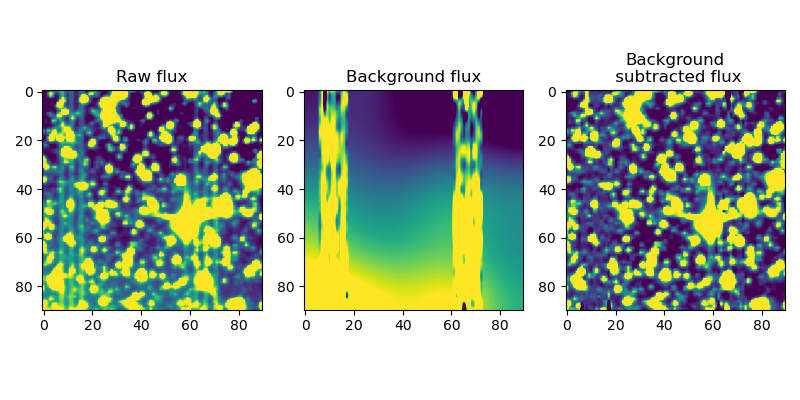

In [8]:
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.title('Raw flux')
plt.imshow(tpf.flux[100],vmax=np.percentile(tpf.flux[100],80),vmin= np.percentile(tpf.flux[100],10))
plt.subplot(132)
plt.title('Background flux')
plt.imshow(bkg[100],vmax=np.percentile(bkg[100],80),vmin= np.percentile(bkg[100],10))
plt.subplot(133)
plt.title('Background\n subtracted flux')
plt.imshow(flux[100],vmax=np.percentile(flux[100],80),vmin= np.percentile(flux[100],10))
plt.tight_layout()

The strap subtraction isn't the greatest, with some sources bleeding through. 

With the background subtracted we can now see SN2019esa, but it still doesnt look that great. The constant gradient through the lightcurve isn't part of the supernova, rather a systematic from the small shifts in the pointing of TESS.

<IPython.core.display.Javascript object>


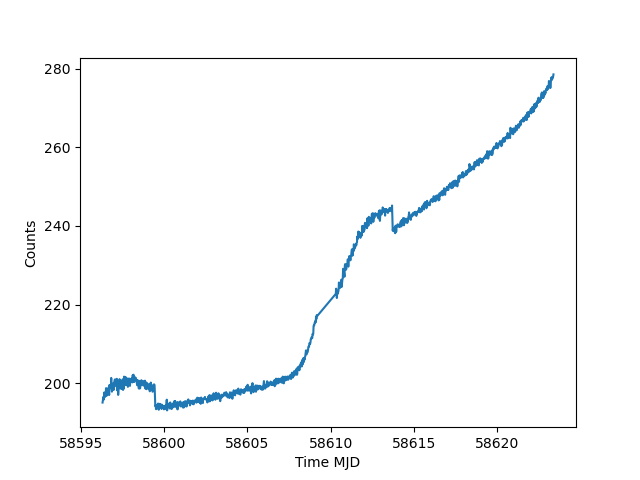

In [9]:
tr.Plotter(tpf.astropy_time.mjd,flux[:,45,45])

To work out how the image shifts throughout the sector, we can use photutils to work out the centroid shifts for each frame.

In [10]:
offset = tr.Centroids_DAO(flux,ref,TPF=tpf)

<IPython.core.display.Javascript object>


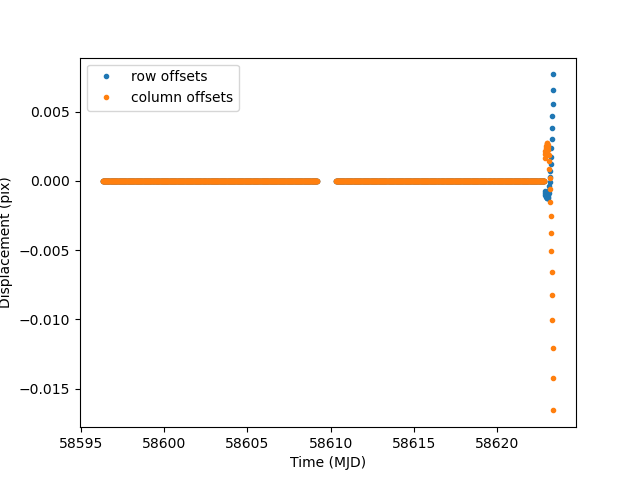

Text(0, 0.5, 'Displacement (pix)')

In [11]:
plt.figure()
plt.plot(tpf.astropy_time.mjd,offset[:,0],'.',label='row offsets')
plt.plot(tpf.astropy_time.mjd,offset[:,1],'.',label='column offsets')
plt.legend()
plt.xlabel('Time (MJD)')
plt.ylabel('Displacement (pix)')

Although these shifts are generally pretty small (<0.01 pix) extended sources, like galaxies, have structure that can move in and out of pixels, causing changes in brightness. Now let's correct for the shift.

<IPython.core.display.Javascript object>


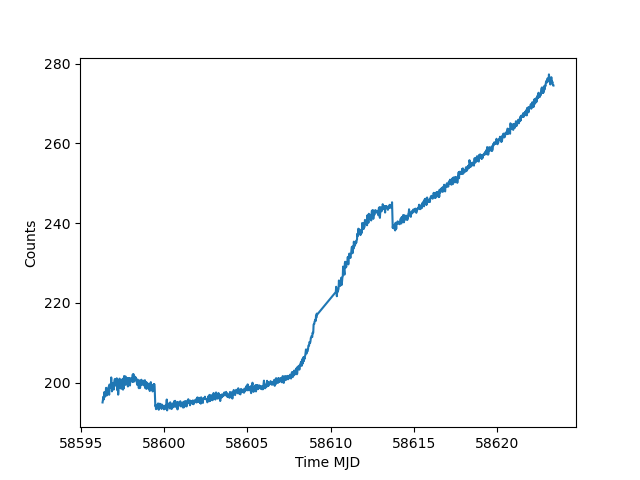

In [12]:
flux = tr.Shift_images(offset,flux)
tr.Plotter(tpf.astropy_time.mjd,flux[:,45,45])

Now we have a pretty good looking light curve! This light curve is just generated with the central pixel, so lets make a better aperture. We can do quick aperture photometry with tr.Make_lc(). If you provide no aperture, then it will use a 3x3 aperture at the centre of the image. If you want to give it a custom aperture, then you can either give it a list of coordinate pairs, referenced from the origin, or a boolean numpy array the same shape as the tpf images.In this case we know the source is at the centre, so the default aperture will work fine!

Often we don't need the full cadence of the TESS FFIs, so we can bin the data to improve the signal to noise. Let's make two lightcurves, one with no binning and the other binned to 12, or 6 hours.

In [13]:
lc = tr.Make_lc(tpf.astropy_time.mjd,flux,bin_size=0,normalise=False)
lc_bin = tr.Make_lc(tpf.astropy_time.mjd,flux,bin_size=12,normalise=False)

In [14]:
lc_bin

array([[58596.42913818, 58596.67913818, 58596.92913818, 58597.17913818,
        58597.42913818, 58597.67913818, 58597.92913818, 58598.17913818,
        58598.42913818, 58598.67913818, 58598.92913818, 58599.17913818,
        58599.42913818, 58599.70001221, 58599.95001221, 58600.20001221,
        58600.45001221, 58600.70001221, 58600.95001221, 58601.20001221,
        58601.45001221, 58601.70001221, 58601.95001221, 58602.20001221,
        58602.45007324, 58602.72088623, 58602.97088623, 58603.22088623,
        58603.47088623, 58603.72088623, 58603.97088623, 58604.22088623,
        58604.47088623, 58604.72088623, 58604.97088623, 58605.22094727,
        58605.47094727, 58605.74176025, 58605.99176025, 58606.24176025,
        58606.49176025, 58606.74176025, 58606.99176025, 58607.24176025,
        58607.49176025, 58607.74176025, 58607.99176025, 58608.24182129,
        58608.49182129, 58608.74182129, 58608.99182129, 58610.3460083 ,
        58610.5960083 , 58610.8460083 , 58611.0960083 , 58611.34

<IPython.core.display.Javascript object>


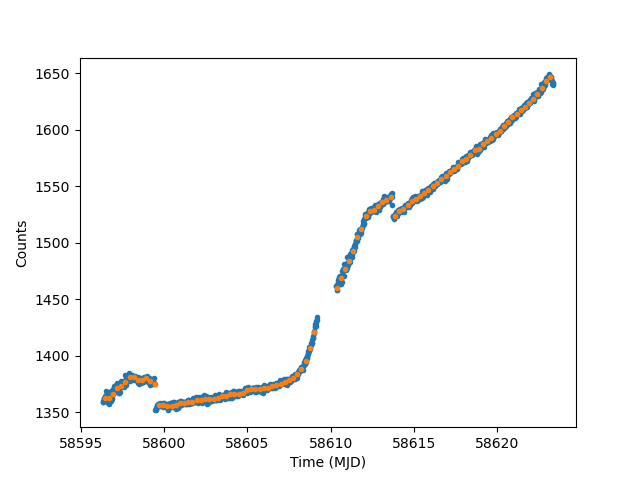

Text(0, 0.5, 'Counts')

In [15]:
plt.figure()
plt.plot(lc[0,:],lc[1,:],'.',label='30 minute')
plt.plot(lc_bin[0,:],lc_bin[1,:],'.',label='6 hour')
#plt.legend()
plt.xlabel('Time (MJD)')
plt.ylabel('Counts')

Now we have a fantastic light curves for SN2019esa!

Those are all the core aspecs of TESSreduce, to get a lightcurve quickly all we actually need to do is:

In [16]:
lc = tr.Quick_reduce(tpf,bin_size=12)

made reference
made source mask
calculating background
background subtracted
calculating centroids
images shifted
made light curve


If you want all of the useful variables it calculates then:

In [17]:
lc, flux, ref, bkg = tr.Quick_reduce(tpf,bin_size=12,all_output=True)

made reference
made source mask
calculating background
background subtracted
calculating centroids
images shifted
made light curve


Since we can see when the supernova explodes, lets make a reference frame that has no supernova flux.

In [18]:
ref = tr.Get_ref(flux,stop=400)

Now we can make a host subtracted lightcurve.

<IPython.core.display.Javascript object>


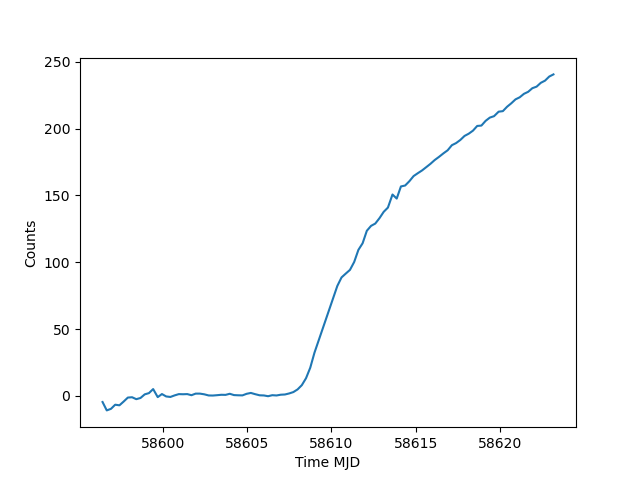

In [19]:
lc = tr.Make_lc(tpf.astropy_time.mjd,flux-ref,bin_size=12)
tr.Plotter(lc[0,:],lc[1,:])